In [7]:
import numpy as np
from kdg import kdf
from kdg.utils import generate_gaussian_parity, hellinger, plot_2dsim, generate_ood_samples
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from joblib import Parallel, delayed
from scipy.io import savemat, loadmat

### Visualize the data

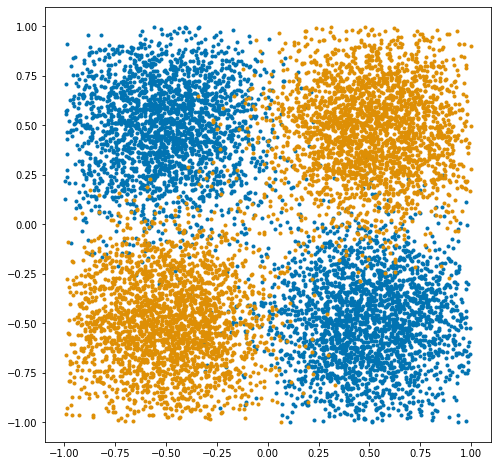

In [39]:
X, y = generate_gaussian_parity(10000)
plot_2dsim(X, y)

### Calculate posteriors and likelihoods using KDF

In [43]:
df = {}
model_kdf = kdf(k=1e-4, kwargs={'n_estimators':500})
model_kdf.fit(X, y)

#define grids
p = np.arange(-2, 2, step=0.01)
q = np.arange(-2, 2, step=0.01)
xx, yy = np.meshgrid(p, q)

grid_samples = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1)
posterior_rf = model_kdf.rf_model.predict_proba(grid_samples)
posterior_kdf, likelihoods_kdf = model_kdf.predict_proba(grid_samples, return_likelihood=True)

posterior_rf = posterior_rf[:,0].reshape(400,400)
posterior_kdf = posterior_kdf[:,0].reshape(400,400)
class1_likelihoods = likelihoods_kdf[:,0].reshape(400,400)
class2_likelihoods = likelihoods_kdf[:,1].reshape(400,400)

df['posterior_rf'] = posterior_rf
df['posterior_kdf'] = posterior_kdf
df['likelihood_class1'] = class1_likelihoods
df['likelihood_class2'] = class2_likelihoods

In [44]:
# get true posterior
tp_df = pd.read_csv("../true_posterior/Gaussian_xor_pdf.csv")
proba_true = 0.5*np.ones((400, 400))
tmp = np.array([tp_df["posterior"][x] for x in range(40000)])
tmp = np.flip(tmp.reshape(200, 200), axis=1)
proba_true[100:300, 100:300] = 1 - tmp
#df["true_proba"] = proba_true

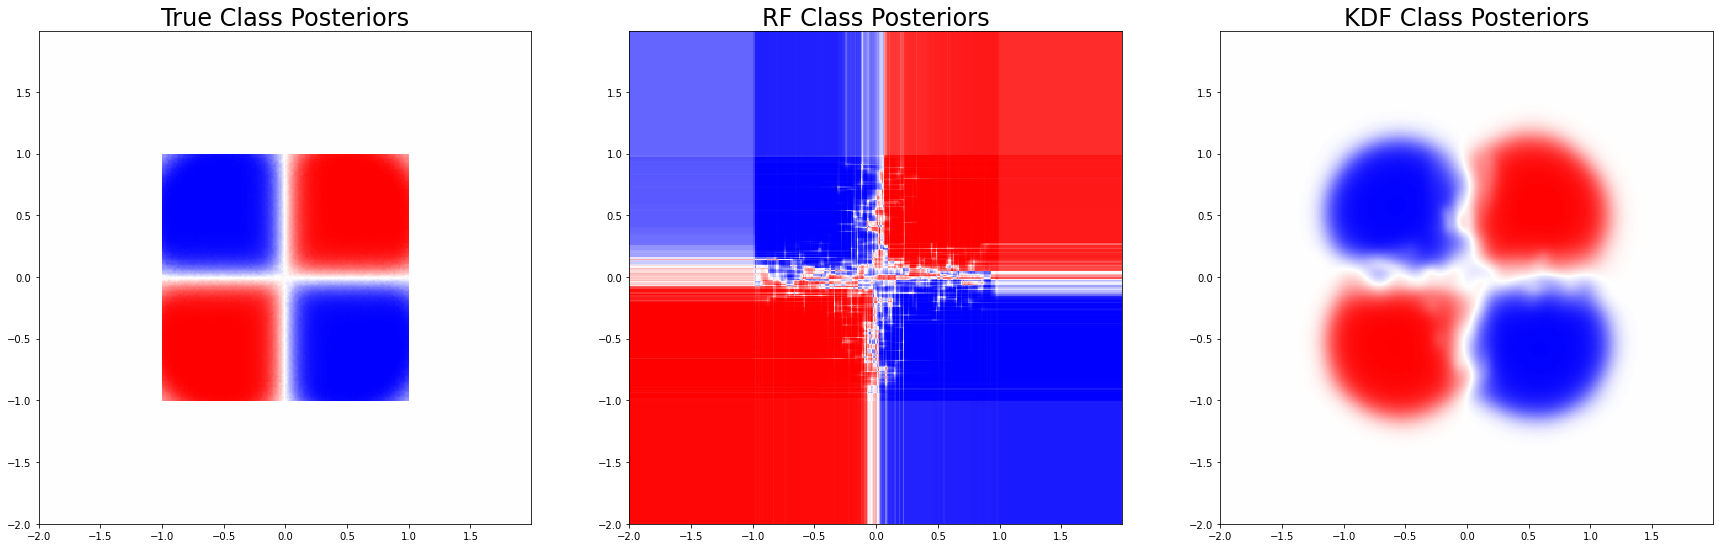

In [45]:
fig1, ax = plt.subplots(1, 3, figsize=(30, 90))

ax0 = ax[0].imshow(
    proba_true,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[0].set_title("True Class Posteriors", fontsize=24)
ax[0].set_aspect("equal")

ax1 = ax[1].imshow(
    posterior_rf,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[1].set_title("RF Class Posteriors", fontsize=24)
ax[1].set_aspect("equal")

ax2 = ax[2].imshow(
    posterior_kdf,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[2].set_title("KDF Class Posteriors", fontsize=24)
ax[2].set_aspect("equal")
plt.show()

### Visualize class likelihoods

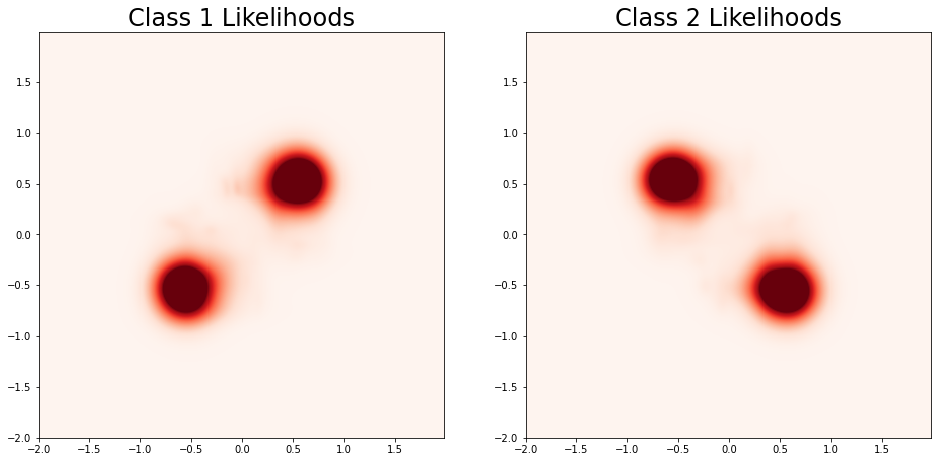

In [49]:
fig1, ax = plt.subplots(1, 2, figsize=(16, 8))

ax0 = ax[0].imshow(
    class1_likelihoods,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="Reds",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[0].set_title("Class 1 Likelihoods", fontsize=24)
ax[0].set_aspect("equal")


ax1 = ax[1].imshow(
    class2_likelihoods,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="Reds",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[1].set_title("Class 2 Likelihoods", fontsize=24)
ax[1].set_aspect("equal")

### Experiment with misclassification error and hellinger distance

In [15]:
mc_reps = 20
sample_size = [10, 50, 100, 500, 1000, 5000, 10000]
n_test = 1000

tp_df = pd.read_csv("../true_posterior/Gaussian_xor_pdf.csv")
true_posterior = tp_df['posterior']

def experiment(sample, n_test, true_posterior):
    X, y = generate_gaussian_parity(sample)
    X_test, y_test = generate_gaussian_parity(n_test)
    X_ood = generate_ood_samples(n_test)

    p = np.arange(-1, 1, step=0.01)
    q = np.arange(-1, 1, step=0.01)
    xx, yy = np.meshgrid(p, q)

    grid_samples = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1)

    model_kdf = kdf(k=1e-4, kwargs={'n_estimators':500})
    model_kdf.fit(X, y)

    error_kdf = 1 - np.mean(model_kdf.predict(X_test)==y_test)
    error_rf = 1 - np.mean(model_kdf.rf_model.predict(X_test)==y_test)
    proba_kdf = model_kdf.predict_proba(grid_samples)
    proba_rf = model_kdf.rf_model.predict_proba(grid_samples)
    hellinger_dis_kdf = hellinger(1-true_posterior, proba_kdf[:,0])
    hellinger_dis_rf = hellinger(1-true_posterior, proba_rf[:,0])
    mmcIn_rf = np.mean(np.max(proba_rf, asix=1))
    mmcOut_rf = np.mean(np.max(model_kdf.rf_model.predict_proba(X_ood), asix=1))
    mmcIn_kdf = np.mean(np.max(proba_kdf, asix=1))
    mmcOut_kdf = np.mean(np.max(model_kdf.predict_proba(X_ood), asix=1))

    return error_kdf, error_rf, hellinger_dis_kdf, hellinger_dis_rf, mmcIn_kdf, mmcOut_kdf, mmcIn_rf, mmcOut_rf

error_kdf_med = []
error_kdf_25 = []
error_kdf_75 = []
error_rf_med = []
error_rf_25 = []
error_rf_75 = []

hellinger_kdf_med = []
hellinger_kdf_25 = []
hellinger_kdf_75 = []
hellinger_rf_med = []
hellinger_rf_25 = []
hellinger_rf_75 = []

mmcIn_kdf_med = []
mmcIn_kdf_25 = []
mmcIn_kdf_75 = []
mmcIn_rf_med = []
mmcIn_rf_25 = []
mmcIn_rf_75 = []

mmcOut_kdf_med = []
mmcOut_kdf_25 = []
mmcOut_kdf_75 = []
mmcOut_rf_med = []
mmcOut_rf_25 = []
mmcOut_rf_75 = []

for sample in sample_size:
    res = Parallel(n_jobs=-1)(
            delayed(experiment)(
                    sample,
                    n_test,
                    true_posterior
                    ) for _ in range(mc_reps)
                )
    
    err_kdf = []
    err_rf = []
    hellinger_kdf = []
    hellinger_rf = []
    mmcIn_kdf = []
    mmcOut_kdf = []
    mmcIn_rf = []
    mmcOut_rf = []
    for ii in range(mc_reps):
        err_kdf.append(res[ii][0])
        err_rf.append(res[ii][1])
        hellinger_kdf.append(res[ii][2])
        hellinger_rf.append(res[ii][3])
        mmcIn_kdf.append(res[ii][4])
        mmcOut_kdf.append(res[ii][5])
        mmcIn_rf.append(res[ii][6])
        mmcOut_rf.append(res[ii][7])

    error_kdf_med.append(
        np.median(err_kdf)
    )
    error_kdf_25.append(
        np.quantile(err_kdf, [0.25])[0]
    )
    error_kdf_75.append(
        np.quantile(err_kdf, [0.75])[0]
    )

    error_rf_med.append(
        np.median(err_rf)
    )
    error_rf_25.append(
        np.quantile(err_rf, [0.25])[0]
    )
    error_rf_75.append(
        np.quantile(err_rf, [0.75])[0]
    )
    
    hellinger_kdf_med.append(
        np.median(hellinger_kdf)
    )
    hellinger_kdf_25.append(
        np.quantile(hellinger_kdf, [0.25])[0]
    )
    hellinger_kdf_75.append(
        np.quantile(hellinger_kdf, [0.75])[0]
    )

    hellinger_rf_med.append(
        np.median(hellinger_kdf)
    )
    hellinger_rf_25.append(
        np.quantile(hellinger_kdf, [0.25])[0]
    )
    hellinger_rf_75.append(
        np.quantile(hellinger_kdf, [0.75])[0]
    )

    mmcIn_kdf_med.append(
        np.median(mmcIn_kdf)
    )
    mmcIn_kdf_25.append(
        np.quantile(mmcIn_kdf, [0.25])[0]
    )
    mmcIn_kdf_75.append(
        np.quantile(mmcIn_kdf, [0.75])[0]
    )

    mmcIn_rf_med.append(
        np.median(mmcIn_rf)
    )
    mmcIn_rf_25.append(
        np.quantile(mmcIn_rf, [0.25])[0]
    )
    mmcIn_rf_75.append(
        np.quantile(mmcIn_rf, [0.75])[0]
    )

    mmcOut_kdf_med.append(
        np.median(mmcOut_kdf)
    )
    mmcOut_kdf_25.append(
        np.quantile(mmcOut_kdf, [0.25])[0]
    )
    mmcOut_kdf_75.append(
        np.quantile(mmcOut_kdf, [0.75])[0]
    )

    mmcOut_rf_med.append(
        np.median(mmcOut_rf)
    )
    mmcOut_rf_25.append(
        np.quantile(mmcOut_rf, [0.25])[0]
    )
    mmcOut_rf_75.append(
        np.quantile(mmcOut_rf, [0.75])[0]
    )

df['error_kdf_med'] = error_kdf_med
df['error_kdf_25'] = error_kdf_25
df['error_kdf_75'] = error_kdf_75

df['error_rf_med'] = error_rf_med
df['error_rf_25'] = error_rf_25
df['error_rf_75'] = error_rf_75

df['hellinger_kdf_med'] = hellinger_kdf_med
df['hellinger_kdf_25'] = hellinger_kdf_25
df['hellinger_kdf_75'] = hellinger_kdf_75

df['hellinger_rf_med'] = hellinger_rf_med
df['hellinger_rf_25'] = hellinger_rf_25
df['hellinger_rf_75'] = hellinger_rf_75

df['mmcIn_kdf_med'] = mmcIn_kdf_med
df['mmcIn_kdf_25'] = mmcIn_kdf_25
df['mmcIn_kdf_75'] = mmcIn_kdf_75

df['mmcIn_rf_med'] = mmcIn_rf_med
df['mmcIn_rf_25'] = mmcIn_rf_25
df['mmcIn_rf_75'] = mmcIn_rf_75

df['mmcOut_kdf_med'] = mmcOut_kdf_med
df['mmcOut_kdf_25'] = mmcOut_kdf_25
df['mmcOut_kdf_75'] = mmcOut_kdf_75

df['mmcOut_rf_med'] = mmcOut_rf_med
df['mmcOut_rf_25'] = mmcOut_rf_25
df['mmcOut_rf_75'] = mmcOut_rf_75

(160000, 2)

### Save the result

In [ ]:
name = 'gxor'
filename = name + "_plot_data.mat"
savemat(filename, df)